In [1]:
import dv_processing as dv
import torch
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.model_loader_refac import ModelLoader
from snn_delays.utils.train_utils_refact_minimal import get_device
from snn_delays.utils.hw_aware_utils import quantize_weights
from snn_delays.utils.hw_aware_utils import save_weights_delays, save_state
import numpy as np
import os
device = 'cpu'

# For reproducibility
torch.manual_seed(10)

In [ ]:
ckpt_dir = 'abcxo_64_Conv_15Hz' # 250, 1e6
model = 'abcxo_conv_64_15Hz_shallow_9842032967032966_max_9epoch'
#model = 'abcxo_conv_64_15Hz_shallow_binary_978021978021978_max_9epoch'

total_time = 250
dataset = 'davis'
folder_name = 'ABCOX_simple_fidelity'

# total_time = 100
# dataset = 'davis_loihi'
# folder_name = 'ABCOX_FromLoihi_Fidelity'

batch_size = 5
#folder_name = 'FromLoihi_ABCXO_15Hz_64_robust'

size = 64

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to=size,
                  folder_name = folder_name)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

snn = ModelLoader(model, ckpt_dir, batch_size, device) 

[CenterCrop(sensor_size=(240, 180, 2), size=(128, 128)), Downsample(time_factor=1, spatial_factor=0.5, sensor_size=None, target_size=None), ToFrame(sensor_size=(64, 64, 2), time_window=None, event_count=None, n_time_bins=250, n_event_bins=None, overlap=0, include_incomplete=False)]
Delta t: 1.0 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully


In [3]:
snn.win = total_time
snn.num_simulation_steps = total_time

snn.debug = True

if 'bin' in model:
    snn.input2spike_th = 0.5

_, __ = snn.test(test_loader)

quant_bits = 8

quantize_weights(snn, quant_bits, last_layer=True, symmetry=True, print_info=True)
_, pred = snn.test(test_loader)

5
Test Loss: 0.006296319887042046
Avg spk_count per neuron for all 250 time-steps 42641.4
Test Accuracy of the model on the test samples: 100.000

----layers.0.conv.weight----
n_unique before quantization: 256, 225 pos 31 neg
max_value before quantization: 0.3613075613975525
n_unique after quantization: 131, 104 pos 27 neg
max_value after quantization: 0.35848483443260193, delta_w: 0.002822715323418379
----layers.2.linear.weight----
n_unique before quantization: 196368, 95793 pos 100575 neg
max_value before quantization: 0.1715363711118698
n_unique after quantization: 197, 83 pos 113 neg
max_value after quantization: 0.17019625008106232, delta_w: 0.001340127899311483
----layers.3.linear.weight----
n_unique before quantization: 480, 235 pos 245 neg
max_value before quantization: 0.5780142545700073
n_unique after quantization: 154, 61 pos 92 neg
max_value after quantization: 0.573498547077179, delta_w: 0.004515736363828182
5
Test Loss: 0.006164480000734329
Avg spk_count per neuron for al

In [4]:
for key in snn.spike_state.keys():
    print(f"{key}: {snn.spike_state[key].shape}")

input: torch.Size([250, 5, 2, 64, 64])
l0: torch.Size([250, 5, 8, 16, 16])
l1: torch.Size([250, 5, 2048])
l2: torch.Size([250, 5, 96])
output: torch.Size([250, 5, 5])


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

spk = snn.spike_state['input'].detach().cpu().numpy()  # Get spikes from layer 1
sample = 4

def plot_channels(index):
    n_channels = spk.shape[2]  # Number of channels (3rd dimension)
    grid_size = int(np.ceil(np.sqrt(n_channels)))  # Calculate grid size
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    fig.suptitle(f'All Channels at First Dimension Index: {index}', fontsize=16)
    
    # Flatten axes array for easy iteration
    axes = axes.ravel()
    
    for channel in range(n_channels):
        img = spk[index, sample, channel, ...]  # Get channel slice
        axes[channel].imshow(img, cmap='viridis')
        axes[channel].set_title(f'Channel {channel}')
        axes[channel].axis('off')
    
    # Hide unused subplots
    for ax in axes[n_channels:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Create interactive slider
interact(
    plot_channels,
    index=IntSlider(
        min=0,
        max=spk.shape[0]-1,
        step=1,
        value=spk.shape[0]//2,
        continuous_update=False,
        description='Index:',
        layout={'width': '500px'}
    )
)

interactive(children=(IntSlider(value=125, continuous_update=False, description='Index:', layout=Layout(width=…

<function __main__.plot_channels(index)>

In [6]:
# import numpy as np
# import matplotlib.pyplot as plt
# from ipywidgets import interact, IntSlider

# spk = snn.spike_state['l0'].detach().cpu().numpy()  # Get spikes from layer 1
# #sample = 0

# def plot_channels(index):
#     n_channels = spk.shape[2]  # Number of channels (3rd dimension)
#     grid_size = int(np.ceil(np.sqrt(n_channels)))  # Calculate grid size
    
#     fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
#     fig.suptitle(f'All Channels at First Dimension Index: {index}', fontsize=16)
    
#     # Flatten axes array for easy iteration
#     axes = axes.ravel()
    
#     for channel in range(n_channels):
#         img = spk[index, sample, channel, ...]  # Get channel slice
#         axes[channel].imshow(img, cmap='viridis')
#         axes[channel].set_title(f'Channel {channel}')
#         axes[channel].axis('off')
    
#     # Hide unused subplots
#     for ax in axes[n_channels:]:
#         ax.axis('off')
    
#     plt.tight_layout()
#     plt.show()

# # Create interactive slider
# interact(
#     plot_channels,
#     index=IntSlider(
#         min=0,
#         max=spk.shape[0]-1,
#         step=1,
#         value=spk.shape[0]//2,
#         continuous_update=False,
#         description='Index:',
#         layout={'width': '500px'}
#     )
# )

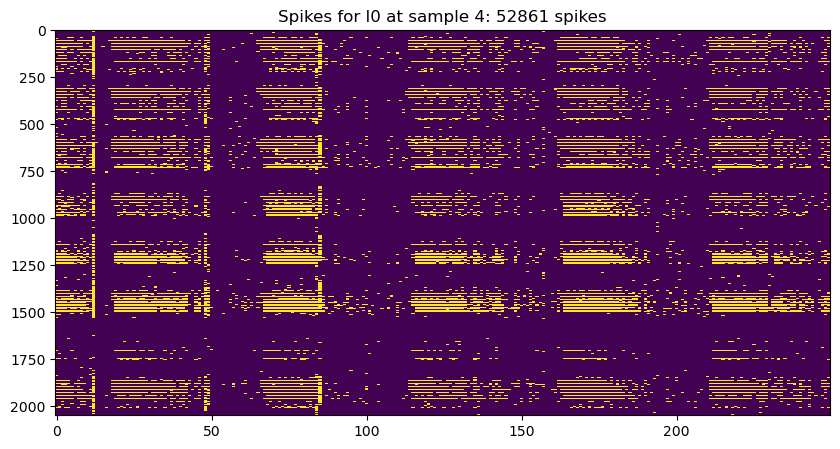

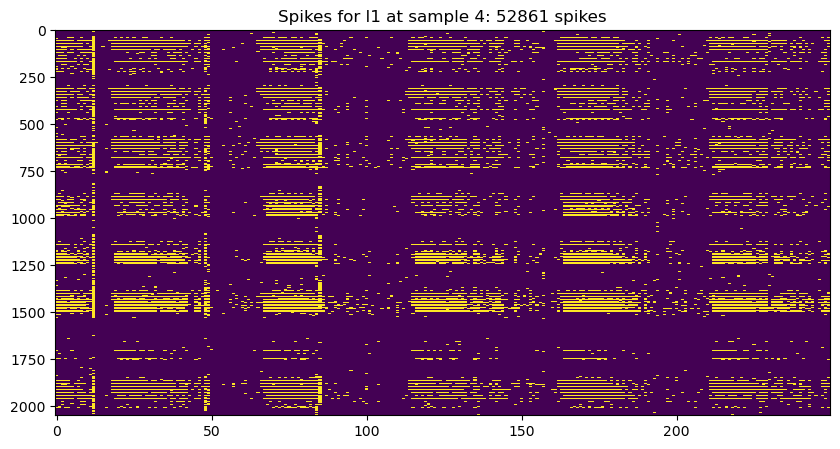

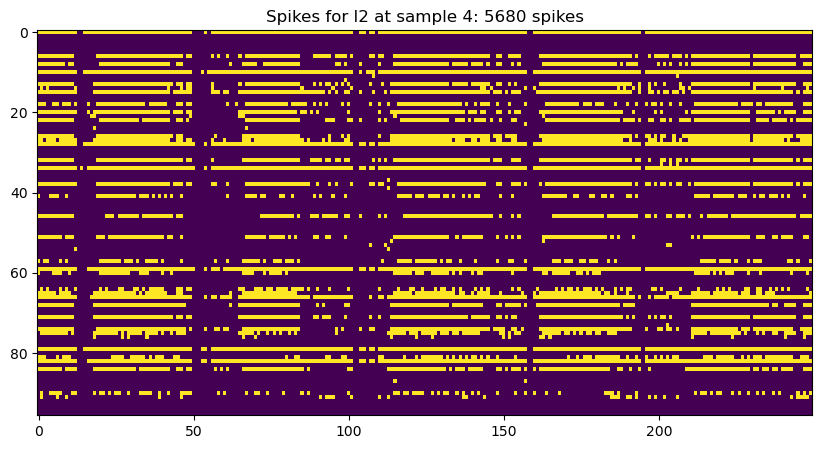

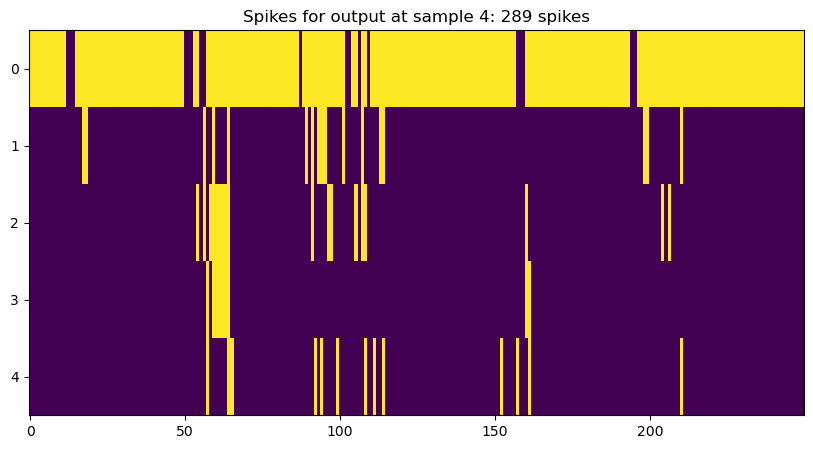

In [7]:
for key in snn.spike_state.keys():
    if key != 'input':
        spk = snn.spike_state[key].detach().cpu().numpy()
        plt.figure(figsize=(10, 5))
        data = spk[:, sample, ...].reshape((total_time, -1)).T
        sum_data = int(np.sum(data))
        plt.imshow(data, aspect='auto', interpolation='none')
        plt.title(f'Spikes for {key} at sample {sample}: {sum_data} spikes')
        np.save(f'spikes_{key}_B.npy', data)

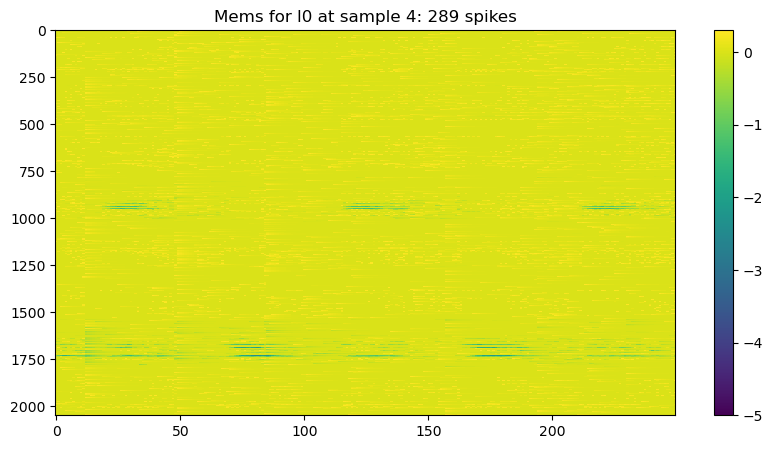

In [8]:
mem = snn.mem_state['l0'].detach().cpu().numpy()
plt.figure(figsize=(10, 5))
data = mem[:, sample, ...].reshape((total_time, -1)).T
plt.imshow(data, aspect='auto', interpolation='none', vmin=-5.0, vmax=0.3)
plt.title(f'Mems for l0 at sample {sample}: {sum_data} spikes')
plt.colorbar()
np.save(f'mems_l0_B.npy', data)

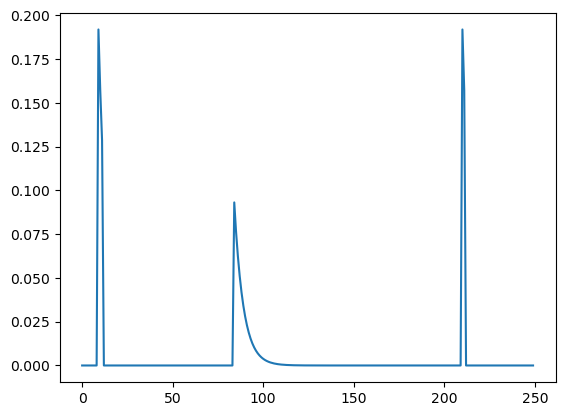

In [9]:
plt.plot(data.T[:, 0])
plt.show()